# Анализ исторических данных о температуре

In [35]:
import pandas as pd
import numpy as np

In [36]:
data = pd.read_csv('temperature_data.csv')

In [37]:
data.head()

,city,timestamp,temperature,season
0,New York,2010-01-01,-2.572540,winter
1,New York,2010-01-02,5.898166,winter
2,New York,2010-01-03,5.264936,winter
3,New York,2010-01-04,3.577332,winter
4,New York,2010-01-05,1.735268,winter


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [39]:
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.normalize()

In [43]:
data.isna().sum()

city           0
timestamp      0
temperature    0
season         0
dtype: int64

In [44]:
data.describe()

,timestamp,temperature
count,54750,54750.000000
mean,2014-12-30 12:00:00,18.301791
min,2010-01-01 00:00:00,-24.353913
25%,2012-07-01 00:00:00,11.133832
50%,2014-12-30 12:00:00,18.796332
75%,2017-06-30 00:00:00,26.146687
max,2019-12-29 00:00:00,57.024863
std,NaN,10.996794


In [45]:
data.describe(include='object')

,city,season
count,54750,54750
unique,15,4
top,New York,spring
freq,3650,13800


## Скользящее среднее

[Алгоритм вычисления простого скользящего среднего](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F#:~:text=.-,%D0%9F%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B5%20%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B5%D0%B5%20%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5,-%5B%D0%BF%D1%80%D0%B0%D0%B2%D0%B8%D1%82%D1%8C%20%7C)

Температуры для которых нельзя посчитать сглаженные значения с заданным окном (январь 2014) остаются неизменными.

In [46]:
def SMA(data, n):
    '''
    Вычесляет простое скользящее среднее для температуры из таблицы data c задынным окном n.
    Таблица должна быть отсортированна по дате.
    '''
    # Предобработка данных
    data_copy = data.copy()
    data_copy['smoothed_temperature'] = data_copy['temperature']
    
    # Подсчет сглаженной температуры для первой доступной даты
    first_value = data_copy.head(n)['temperature'].mean()
    first_index = data_copy.iloc[n - 1].name
    data_copy.loc[first_index, 'smoothed_temperature'] = first_value
    
    # Подготовка данных для вычисления сглаживающих значений по рекурентной формуле
    global prev_SMA
    
    prev_SMA = data_copy.loc[first_index]['smoothed_temperature']
    data_copy[f'temp_{n}_days_ago'] = data_copy['temperature'].shift(n)
    
    # Вычесление остальных сглаженных температур
    def recurrent_SMA(x):
        '''
        Функция для pd.apply: вычисляет сглаженную температуру по значениям текущего и предыдущего объекта.
        '''
        global prev_SMA
        
        x['smoothed_temperature'] = prev_SMA - x[f'temp_{n}_days_ago'] / n + x['temperature'] / n
        
        prev_SMA = x['smoothed_temperature']
        
        return x
    
    data_copy.iloc[n:] = data_copy.iloc[n:].apply(recurrent_SMA, axis=1)
    
    return data_copy['smoothed_temperature']

In [47]:
for city in pd.unique(data['city']):
    sorted_data = data[data['city'] == city].sort_values('timestamp')
    smoothed_temperature = SMA(data[data['city'] == city], 30)
    data.loc[smoothed_temperature.index, 'smoothed_temperature'] = smoothed_temperature

In [49]:
data

,city,timestamp,temperature,season,smoothed_temperature
0,New York,2010-01-01,-2.572540,winter,-2.572540
1,New York,2010-01-02,5.898166,winter,5.898166
2,New York,2010-01-03,5.264936,winter,5.264936
3,New York,2010-01-04,3.577332,winter,3.577332
4,New York,2010-01-05,1.735268,winter,1.735268
...,...,...,...,...,...
54745,Mexico City,2019-12-25,10.558139,winter,12.031199
54746,Mexico City,2019-12-26,5.051404,winter,11.936984
54747,Mexico City,2019-12-27,9.463439,winter,11.698947
54748,Mexico City,2019-12-28,9.757999,winter,11.467487


In [50]:
data.describe()

,timestamp,temperature,smoothed_temperature
count,54750,54750.000000,54750.000000
mean,2014-12-30 12:00:00,18.301791,18.300746
min,2010-01-01 00:00:00,-24.353913,-22.670607
25%,2012-07-01 00:00:00,11.133832,12.098036
50%,2014-12-30 12:00:00,18.796332,18.593160
75%,2017-06-30 00:00:00,26.146687,25.773623
max,2019-12-29 00:00:00,57.024863,42.133612
std,NaN,10.996794,9.623177


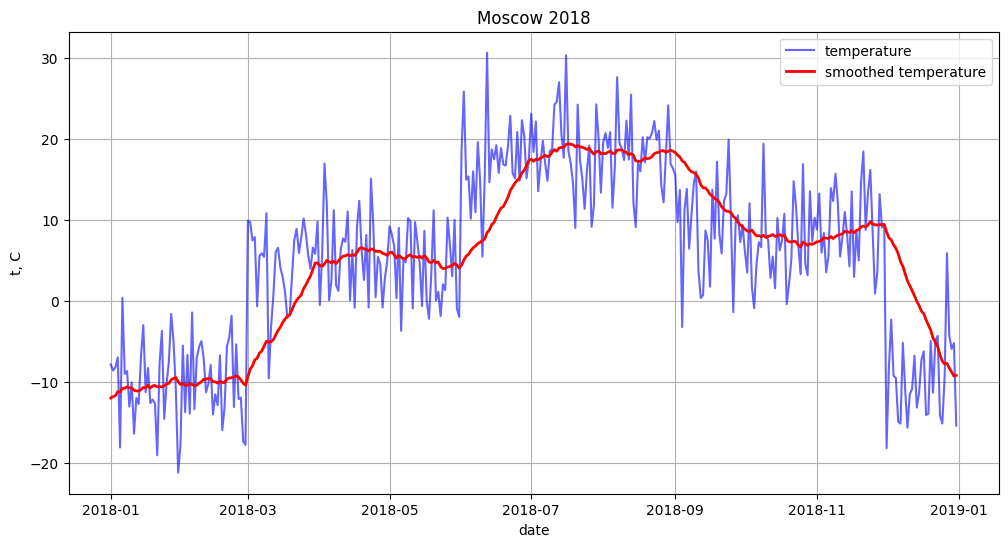

In [54]:
import matplotlib.pyplot as plt

moscow_data = data[(data['city'] == 'Moscow') & (data['timestamp'].dt.year == 2018)]

plt.figure(figsize=(12, 6))

plt.plot(moscow_data['timestamp'], moscow_data['temperature'], label='temperature', color='blue', alpha=0.6)

plt.plot(moscow_data['timestamp'], moscow_data['smoothed_temperature'], label='smoothed temperature', color='red', linewidth=2)

plt.xlabel('date')
plt.ylabel('t, C')
plt.title('Moscow 2018')

plt.legend()

plt.grid(True)

plt.show()
